# Lab 7
## Regression Discontinuity
2/28/2018

### Announcements:
* Office hours for the month of March will be 2pm-4pm Tuesdays in room N355.
* Please see the course syllabus for our re-grade policy.  I do not grade your assignments/exams, and cannot address specific questions about grades.  See the rubric announced on bcourses (and sent over email) for a general guide.
* Apologies for the lag in posting module 7.  The person responsible for writing the module was delayed in completing it due to illness, but we will hopefully have it posted by the end of this week.  Everything you need to complete today's section of the next problem set can be found in this notebook, including the problem set question.  Take a look at the module later as an additional resource, but core skills will be covered here.

### Plan for Today's Lab
1. Quick discussion of RD and when it's appropriate (5-10 minutes)
2. Graphical RD analysis (5-10 minutes)
3. Regression for a sharp RD (5-10 minutes)

## 1- Discussion
RD is useful in any situation where a "cutoff" is used to assign treatment.  One of the biggest concerns with this strategy for identifying a causal effect is that people just above/below the cutoff have selected into their position relative to the cutoff.  For example consider a program that automatically gives out a scholarships for students scoring above a certain cutoff on the SATs.  If we were to estimate the effect of the scholarship on probability of attending college using an RD approach, what concerns might we have about the validity of our approach?

In [1]:
# Clear Environment 
rm(list = ls())
# Clear Console
cat('\014')

# Load required packages
require(dplyr)
require(ggplot2)
require(miceadds)
require(multiwayvcov)


# Set working directory to the location of your data files/
# setwd("/home/jovyan/mba217-2/Data")

# Read the data 
# This is the same dataset we have been using, but with additional variables for the RD
# Data has already been limited to treatment group only in 1999 (endline)
PROGRESA_RD <- read.csv('../Data/PROGRESA_RD.csv')

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: miceadds
Loading required package: mice
Loading required package: lattice
* miceadds 2.9-15 (2017-12-18 11:50:04)
Loading required package: multiwayvcov


## 2-Graphical RD analysis
In  most cases, we want to start RD analysis by examining the data visually.  We'll do this by "binning" the forcing variable (the variable for which a cutoff determines assignment to treatment), which just means that we'll group it into a value range.  For example, all values (0 to less than 10) would be set to 0, all values (10 to less than 20) would be set to 10.  

We will also limit the data to a range around the forcing variable-- we want to focus on data close to the cutoff.

Here, we'll consider the PROGRESA RCT again.  In addition to treatment being randomly assigned to villages, individuals within treatment villages were only eligible to receive the transfer program if they were below a cutoff of a poverty index created by the Mexican government.  In our data, the households value for the index relative to the cutoff is represented by the variable z.  Households with z<=0 were eligible for PROGRESA and those with z>0 were not.

In [2]:
cut_interval(1:10, length = 2)

[1] [0,2]  [0,2]  (2,4]  (2,4]  (4,6]  (4,6]  (6,8]  (6,8]  (8,10] (8,10]
Levels: [0,2] (2,4] (4,6] (6,8] (8,10]

In [3]:
#First we will limit the data households within 200 points of a poverty index cutoff 
# This cutoff determined assignment to treatment 
    sampleRD <- subset(PROGRESA_RD,  ( PROGRESA_RD$z>=-200 & PROGRESA_RD$z<=200) ) 

#Here, we create bins of 10 points on the poverty index
    sampleRD<-sampleRD[order(sampleRD$z),]
    sampleRD$bin0<-cut_interval(sampleRD$z, length=10, labels = FALSE)
    sampleRD$bin<- -210+(sampleRD$bin0*10)
    summary(sampleRD$bin)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-200.00 -110.00  -50.00  -40.52   30.00  190.00 

In [4]:
head(sampleRD, 2)
unique(sampleRD[sampleRD$bin >-200 & sampleRD$bin < 0, "bin"])

,X,entidad,hogid,iid,year,n002,n009,enroll_child,contba,pobreden,⋯,D,pov_HH,D_HH,uniqhh,D_assign,maxcut,z,E,bin0,bin
722,3187,13,350834,3508343,1999,17,NA,0,basal,pobre,⋯,1,1,1,0,1,753,-200,1,1,-200
1483,7114,13,350834,3508344,1999,13,NA,si,basal,pobre,⋯,1,1,1,1,1,753,-200,1,1,-200


[1] -190 -180 -170 -160 -150 -140 -130 -120 -110 -100  -90  -80  -70  -60  -50
[16]  -40  -30  -20  -10

Here, we are going to focus on the variable of child enrollment in school as our outcome.  We want to compare enrollment rates for those just below and above the cutoff, so we calculate the mean enrollment values for each of the bins we created above and plot these means against the forcing variable (relative poverty index).  We will also fit regression lines for below and above the cutoff.

Warning message:
“Removed 20 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 20 rows containing non-finite values (stat_smooth).”

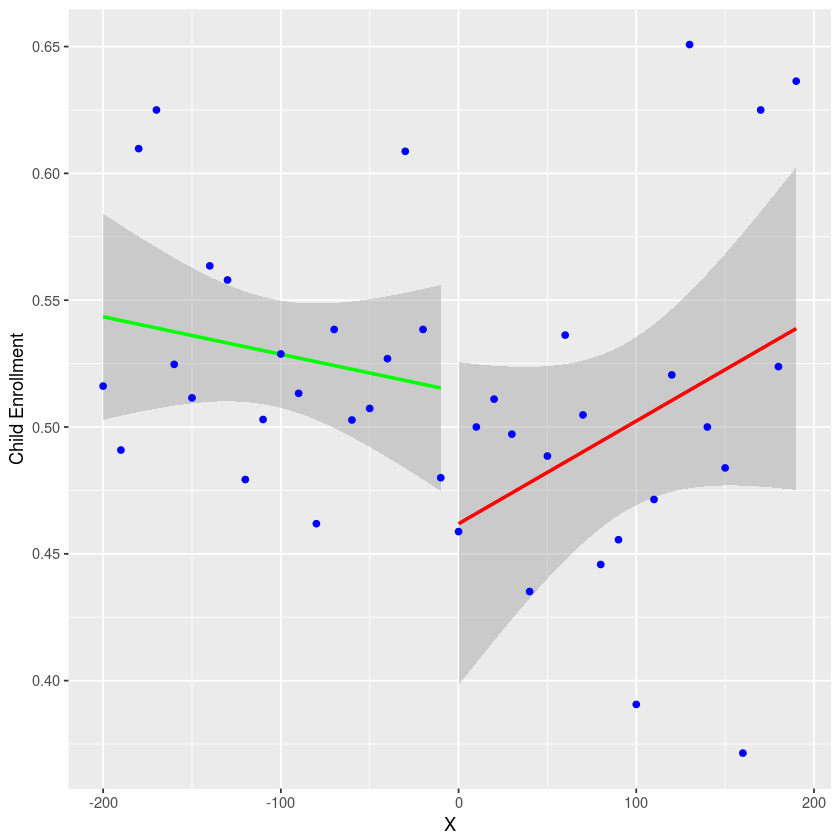

In [5]:
    #Make enroll_child factor variable and limit datset to only relevant variables
    sampleRD$enroll_child<-ifelse(sampleRD$enroll_child == "si" ,1,0)
    v<-c("bin", "z", "enroll_child")
    sampleRD2<-sampleRD[v]
    
    #collapse dataset to get bin means
    aggdata <-aggregate(sampleRD2, by=list(sampleRD2$bin), FUN=mean, na.rm=TRUE)

    #create separate variables for below and above cutoff
    aggdata$below<-aggdata$enroll_child
    aggdata$below[aggdata$bin>=0]<-NA
    aggdata$above<-aggdata$enroll_child
    aggdata$above[aggdata$bin<0]<-NA

    #Plot bin averages 
    L <- aggdata %>% ggplot(aes(bin, enroll_child)) 
    P <- geom_point(color='blue')
    ## add fit lines for above/below cutoff
    L <- L + geom_smooth(color='red',method='lm', formula=y~x, aes(aggdata$bin, aggdata$above))
    L <- L + geom_smooth(color='green',method='lm', formula=y~x, aes(aggdata$bin, aggdata$below))
    
    #Display Plot
    L+P + xlab("X") +  ylab("Child Enrollment")

In [6]:
nrow(aggdata)

[1] 40

In [7]:
group_by(sampleRD2, bin) %>%
             summarise(enroll_child = mean(enroll_child, na.rm = T),
                       z = mean(z, na.rm = T)) %>% ungroup  == aggdata[, c(2,4,3)]

bin,enroll_child,z
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE


In [8]:
head(aggdata)

Group.1,bin,z,enroll_child,below,above
-200,-200,-194.5403,0.5161290,0.5161290,NA
-190,-190,-184.5225,0.4909091,0.4909091,NA
-180,-180,-174.8760,0.6097561,0.6097561,NA
-170,-170,-164.7195,0.6250000,0.6250000,NA
-160,-160,-154.6850,0.5246914,0.5246914,NA
-150,-150,-144.7818,0.5114943,0.5114943,NA


## 3- Regression for a Sharp RD
If we assume that everyone below the cutoff received treatment and everyone above did not receive treatment, we can run a regression using an indicator for "below the cutoff" as the independent variable, that estimates the treatment effect on the dependent variable.  We also control for the forcing variable (X, the poverty index) and should try doing this linearly and with other functional forms (e.g. quadratic)  Again, we want to make sure we limit the data to be relatively close to the cutoff (we've already limited to +-200).  

In [12]:
head(sampleRD[, c("z", "pov_HH")], 2)
head(sampleRD[sampleRD$z == 0, c("z", "pov_HH")], 2)
summary(sampleRD[, c("z", "pov_HH")])

,z,pov_HH
722,-200,1
1483,-200,1


,z,pov_HH
435,0,1
1479,0,1


       z               pov_HH      
 Min.   :-200.00   Min.   :0.0000  
 1st Qu.:-109.00   1st Qu.:0.0000  
 Median : -41.50   Median :1.0000  
 Mean   : -35.31   Mean   :0.6403  
 3rd Qu.:  30.77   3rd Qu.:1.0000  
 Max.   : 200.00   Max.   :1.0000  

In [10]:
    #Cluster at the village level and inlude a linear control for z
　# lm.cluster(data = sampleRD, formula= enroll_child ~ z, cluster=sampleRD$villid)
    #pov_HH=1 is the indicator for being below the cutoff
    model <- lm.cluster(data = sampleRD, formula= enroll_child ~ pov_HH+z, cluster=sampleRD$villid)
    summary(model)
    #next, try a quadratic control for z
    sampleRD$z2<-sampleRD$z^2
    model2 <- lm.cluster(data = sampleRD, formula= enroll_child ~ pov_HH+z+z2, cluster=sampleRD$villid)
    summary(model2)

R^2 = 0.00119 

                 Estimate   Std. Error    t value      Pr(>|t|)
(Intercept)  4.943732e-01 0.0195547719 25.2814633 5.108385e-141
pov_HH       2.953866e-02 0.0281280015  1.0501512  2.936486e-01
z           -3.816885e-05 0.0001534685 -0.2487079  8.035867e-01
R^2 = 0.00178 

                Estimate   Std. Error    t value      Pr(>|t|)
(Intercept) 4.789523e-01 2.252099e-02 21.2669323 2.298280e-100
pov_HH      3.885764e-02 2.869374e-02  1.3542201  1.756662e-01
z           5.639947e-05 1.648254e-04  0.3421771  7.322176e-01
z2          1.285038e-06 8.800953e-07  1.4601123  1.442592e-01


## Problem Set Question 7.1
(a) Repeat what we've done above (Graph and Sharp RD regressions) for at least two separate versions, varying the choice for the values of Z we include in the sample (band size-- something other than +-200) in one version, and the bin size in another (something other than 10).  Interpret the results of the graphs and regression.  What effect do the selected bin and band size have on the results?  
(b) In the above analysis, we compare household within treatment villages.  Describe at least one reason we might be concerned that a comparison of households below and above the cutoff to identify the treatment effect of PROGRESA might lead to a biased result.